
# **MVP: *Machine Learning & Analytics***
**Autor:** Gustavo Alves  

**Data:** 27/08/2025

**Matrícula:** 4052025001911

**Dataset:** [Chess Game Dataset](https://www.kaggle.com/datasets/adityajha1504/chesscom-user-games-60000-games)

---

## **1. Escopo, objetivo e definição do problema**

### **Definição sobre o esporte xadrez**

- É um jogo de tabuleiro entre duas pessoas

- Cada jogador recebe peças de uma cor, geralmente peças brancas para um e peças pretas para o outro;

- Chamarei de `BRANCAS` o jogador(a) com peças brancas e o de `PRETAS` o jogador(a) com peças pretas

- Classificação ELO (ELO Rating): medida de força dos jogadores, atualizada conforme o resultado das partidas. Esta é uma metodologia de classificação já conhecida para xadrez.

&nbsp;  
&nbsp;  

### **Objetivo principal**

- Prever, antes do início da partida, se as peças brancas vencerão (win) ou não vencerão (not_win = draw ou lose).

### **Contexto do problema**

- Dataset publicado no Kaggle: [Chess Game Dataset](https://www.kaggle.com/datasets/adityajha1504/chesscom-user-games-60000-games)

- Conjunto de ~60 mil partidas públicas da Chess.com, coletadas via API (dataset em EN-US; textos do notebook em PT-BR).

- Usarei **somente as informações pré-jogo** (ratings, diferença de rating, controle de tempo, abertura/ECO, etc.). Não avaliarei lances;

- Ao final, compararei o modelo com um baseline Elo (probabilidade esperada das brancas a partir da diferença de rating).

### **Tipo de tarefa**

- Classificação binária: {win, not_win}. O rótulo not_win agrega draw e lose. A mudança do escopo (de multiclasse para binária) foi uma decisão da EDA, pela baixa frequência de draw e pela proximidade lógica entre draw e lose.

### **Área de aplicação**

- Dados tabulares estruturados com variáveis numéricas e categóricas;

- Aplicarei conceitos de Análise Preditiva e Machine Learning;

### **Valor para o usuário/negócio**

- Jogadores: entender quais fatores pré-jogo mais influenciam o resultado por ritmo de tempo;

- Plataformas/torneios: estimar probabilidades de resultado para pareamentos e alocação de mesas por tempo;

## **2. Reprodutibilidade e ambiente**

In [1]:
# === Imports principais ===
import sys, time, random, warnings, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display  # exibir DataFrames no meio da célula, não apenas no final
from google.colab import drive       # carregar dados do Google Drive. Utilizei para testes

# === Scikit-learn: validação, pré-processamento e modelos ===
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate

# Modelos
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Métricas
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    log_loss, classification_report, confusion_matrix,
    average_precision_score, brier_score_loss,
    roc_curve, precision_recall_curve
)

# === Configurações globais ===
run_svm = False # O SVM deixa o modelo rodando por horas. Alterar para True se deseja rodar com SVM ou para False se deseja rodar sem o SVM
kfold_partitions = 10
SEED = 42
random.seed(SEED)
np.random.seed(SEED)  # obs: em sklearn, controle adicional via random_state= nos estimadores

# ======= ESCOLHA MANUAL DO THRESHOLD =======
TAU = 0.5
# ===========================================


# === Melhorar visualização no pandas ===
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

# ====== Iniciar Temporizador ======
t0 = time.perf_counter()

Python: 3.12.11
Seed global: 42


## **3. Dados: carga, entendimento e qualidade**

### **3.1 Carga e Apresentação do Dataset**

#### **Nomes de colunas e suas definições**

- **white_username** — nome de usuário das `BRANCAS`
- **black_username** — nome de usuário das `PRETAS`
- **white_id** — link do perfil do jogador das `BRANCAS`
- **black_id** — link do perfil do jogador das `PRETAS`
- **white_rating** — ELO das `BRANCAS` antes da partida
- **black_rating** — ELO das `PRETAS` antes da partida
- **white_result** — resultado do ponto de vista das `BRANCAS` (ver dicionário abaixo)
- **black_result** — resultado do ponto de vista das `PRETAS` (ver dicionário abaixo)
- **time_class** — classe de tempo (bullet, blitz, rapid or daily)
- **time_control** — controle de tempo no formato base+incremento (ex.: 180+2 = 180s por lado, incremento de 2s por lance).
- **rules** — variante (ex.: chess para xadrez clássico; podem existir outras variantes como chess960)
- **rated** — partida ranqueada (1/True) ou casual (0/False).
- **fen** — Forsyth-Edwards Notation, descreve uma posição do tabuleiro
- **pgn** — Portable Game Notation, texto com metadados e lances da partida.

&nbsp;

#### **Definições de Valores em colunas específicas**

##### **Resultados das Partidas** white_results & black_results

Os rótulos são registrados do ponto de vista de cada cor:

- **win** — vitória (usado em algumas tabelas como rótulo genérico sem detalhar motivo).
- **checkmated** — derrota por xeque-mate.
- **resigned** — derrota por abandono (o jogador desistiu).
- **timeout** — derrota por tempo (relógio zerou).
- **stalemate** — afogamento (sem lance legal e sem xeque) &#8594; empate.
- **agreed** — empate por acordo.
- **repetition** — empate por repetição (três repetições).
- **50move** — empate pela regra dos 50 lances (sem captura nem movimento de peão).
- **insufficient** — material insuficiente para mate &#8594; empate.
- **timevsinsufficient** — um lado cai por tempo, mas o outro não tem material para mate &#8594; empate.
- **abandoned** — partida abandonada/conexão perdida; costuma contar como derrota de quem abandonou.
- **threecheck**, kingofthehill — rótulos associados a variantes (não ao xadrez clássico).

&nbsp;

##### **Controle de Tempo** — time_class

- **bullet** — partidas muito rápidas (geralmente < 3 min por lado).
- **blitz** — partidas rápidas (de 3–10 min por lado).
- **rapid** — partidas rápidas/longas curtas (de 10–30 min por lado).
- **daily** — partidas por correspondência (tempo em dias por lance, ex.: 1/259200 = 3 dias).


Para referências do Chess.com sobre controles de tempo: [Time Controls](https://www.chess.com/terms/chess-time-controls)

In [2]:
# ====== Carga dos dados ======

# Para CSV no google drive
# drive.mount('/content/drive')
# dataset_url="/content/drive/MyDrive/Colab Notebooks/Analise mercado imobiliario/club_games_dataset_chess_dot_com.csv"

# Para CSV no repo do GitHub
dataset_url = "https://media.githubusercontent.com/media/gustavo-alves-repo/pucrj-mvp-sprint-2-machine-learning/refs/heads/main/club_games_dataset_chess_dot_com.csv"

# Tipagem e parsing
dtype_map = {
    "white_username": "string",
    "black_username": "string",
    "white_id": "string",
    "black_id": "string",
    "white_rating": "Int64",
    "black_rating": "Int64",
    "white_result": "string",
    "black_result": "string",
    "time_class": "string",
    "time_control": "string",
    "rules": "string",
    "rated": "boolean",
    "fen": "string",
    "pgn": "string",
}

dataset = pd.read_csv(
    dataset_url,
    delimiter=',',
    dtype=dtype_map,
    na_values=["", "NA", "NaN", None],
    low_memory=False,
)

# ====== Visão geral ======
print("Shape:", dataset.shape)

print(
    f"\nMemória aproximada: "
    f"{round(dataset.memory_usage(deep=True).sum() / 1024**2,2)} MB"
)

print("\nPrimeiras linhas (exemplo):")
display(dataset.head().style.set_properties(**{"white-space": "nowrap"}))

print("\nInfo das colunas:")
display(dataset.info())

Shape: (66879, 14)

Memória aproximada: 190.2 MB

Primeiras linhas (exemplo):


,white_username,black_username,white_id,black_id,white_rating,black_rating,white_result,black_result,time_class,time_control,rules,rated,fen,pgn
0,-Amos-,miniman2804,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/miniman2804,1708,1608,win,checkmated,daily,1/259200,chess,True,r2r4/p2p1p1p/b6R/n1p1kp2/2P2P2/3BP3/PP5P/4K2R b K f3 1 22,"[Event ""Enjoyable games 2 - Round 1""] [Site ""Chess.com""] [Date ""2013.01.30""] [Round ""-""] [White ""-Amos-""] [Black ""miniman2804""] [Result ""1-0""] [Tournament ""https://www.chess.com/tournament/enjoyable-games-2""] [CurrentPosition ""r2r4/p2p1p1p/b6R/n1p1kp2/2P2P2/3BP3/PP5P/4K2R b K f3 1 22""] [Timezone ""UTC""] [ECO ""E22""] [ECOUrl ""https://www.chess.com/openings/Nimzo-Indian-Defense-Spielmann-Variation""] [UTCDate ""2013.01.30""] [UTCTime ""16:35:14""] [WhiteElo ""1708""] [BlackElo ""1608""] [TimeControl ""1/259200""] [Termination ""-Amos- won by checkmate""] [StartTime ""16:35:14""] [EndDate ""2013.02.01""] [EndTime ""18:14:48""] [Link ""https://www.chess.com/game/daily/64629816""] 1. d4 Nf6 2. c4 e6 3. Nc3 Bb4 4. Qb3 Bxc3+ 5. Qxc3 O-O 6. Bg5 c5 7. dxc5 Nc6 8. Nf3 Qa5 9. Bxf6 gxf6 10. Qxa5 Nxa5 11. e3 Rd8 12. Rd1 Kg7 13. Be2 b6 14. Rd4 bxc5 15. Rg4+ Kh6 16. Bd3 f5 17. Rh4+ Kg6 18. g4 Ba6 19. gxf5+ exf5 20. Ne5+ Kf6 21. Rh6+ Kxe5 22. f4# 1-0"
1,-Amos-,koltcho69,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/koltcho69,1726,1577,win,resigned,daily,1/172800,chess,True,8/5Q1k/4n1pp/8/7P/2N2b2/PP3P2/5K2 b - - 1 33,"[Event ""Rapid Rats - Board 5""] [Site ""Chess.com""] [Date ""2013.01.19""] [Round ""-""] [White ""-Amos-""] [Black ""koltcho69""] [Result ""1-0""] [Match ""https://www.chess.com/club/matches/219602""] [CurrentPosition ""8/5Q1k/4n1pp/8/7P/2N2b2/PP3P2/5K2 b - - 1 33""] [Timezone ""UTC""] [ECO ""C53""] [ECOUrl ""https://www.chess.com/openings/Giuoco-Piano-Game-Main-Line""] [UTCDate ""2013.01.19""] [UTCTime ""14:29:25""] [WhiteElo ""1726""] [BlackElo ""1577""] [TimeControl ""1/172800""] [Termination ""-Amos- won by resignation""] [StartTime ""14:29:25""] [EndDate ""2013.02.01""] [EndTime ""18:22:03""] [Link ""https://www.chess.com/game/daily/64070770""] 1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. c3 a6 5. d4 exd4 6. cxd4 Be7 7. Qb3 Na5 8. Qc2 Nxc4 9. Qxc4 d6 10. Nc3 c6 11. O-O h6 12. Re1 Nf6 13. d5 c5 14. e5 dxe5 15. Nxe5 O-O 16. Ng6 Re8 17. Rxe7 Rxe7 18. Nxe7+ Qxe7 19. Bf4 b5 20. d6 Qd7 21. Qxc5 Bb7 22. Qc7 Qxc7 23. dxc7 Nd5 24. Rd1 Nxf4 25. Rd8+ Kh7 26. Rxa8 Bxa8 27. c8=Q Bxg2 28. Qxa6 Bf3 29. Qxb5 Nh3+ 30. Kf1 g6 31. Qd7 Ng5 32. h4 Ne6 33. Qxf7+ 1-0"
2,-Amos-,enhmandah,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/enhmandah,1727,842,win,resigned,daily,1/172800,chess,True,rn1q1b1r/kb2p1pp/2p5/p1Q5/N1BP2n1/4PN2/1P3PPP/R1B1K2R b KQ - 5 15,"[Event ""CHESS BOARD CLASH - Round 1""] [Site ""Chess.com""] [Date ""2013.02.01""] [Round ""-""] [White ""-Amos-""] [Black ""enhmandah""] [Result ""1-0""] [Tournament ""https://www.chess.com/tournament/just-another-clash""] [CurrentPosition ""rn1q1b1r/kb2p1pp/2p5/p1Q5/N1BP2n1/4PN2/1P3PPP/R1B1K2R b KQ - 5 15""] [Timezone ""UTC""] [ECO ""D00""] [ECOUrl ""https://www.chess.com/openings/Queens-Pawn-Opening-1...d5-2.e3""] [UTCDate ""2013.02.01""] [UTCTime ""11:24:19""] [WhiteElo ""1727""] [BlackElo ""842""] [TimeControl ""1/172800""] [Termination ""-Amos- won by resignation""] [StartTime ""11:24:19""] [EndDate ""2013.02.02""] [EndTime ""17:58:11""] [Link ""https://www.chess.com/game/daily/64714474""] 1. d4 d5 2. e3 c6 3. c4 dxc4 4. Bxc4 b5 5. Bb3 a5 6. Qf3 Bb7 7. Bxf7+ Kd7 8. Qf5+ Kc7 9. Nf3 Nh6 10. Qe5+ Kb6 11. a4 bxa4 12. Nc3 Ng4 13. Nxa4+ Ka6 14. Bc4+ Ka7 15. Qc5+ 1-0"
3,enhmandah,-Amos-,https://api.chess.com/pub/player/enhmandah,https://api.chess.com/pub/player/-amos-,819,1727,checkmated,win,daily,1/172800,chess,True,r3kb1r/pp3ppp/3p1n2/2pKp3/P3P3/1P6/4qP1P/QNB5 w kq - 3 17,"[Event ""CHESS BOARD CLASH - Round 1""] [Site ""Chess.com""] [Date ""2013.02.01""] [Round ""-""] [White ""


Info das colunas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66879 entries, 0 to 66878
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   white_username  66879 non-null  string 
 1   black_username  66879 non-null  string 
 2   white_id        66879 non-null  string 
 3   black_id        66879 non-null  string 
 4   white_rating    66879 non-null  Int64  
 5   black_rating    66879 non-null  Int64  
 6   white_result    66879 non-null  string 
 7   black_result    66879 non-null  string 
 8   time_class      66879 non-null  string 
 9   time_control    66879 non-null  string 
 10  rules           66879 non-null  string 
 11  rated           66879 non-null  boolean
 12  fen             66879 non-null  string 
 13  pgn             66879 non-null  string 
dtypes: Int64(2), boolean(1), string(11)
memory usage: 6.9 MB


None

#### **Conclusão**

- **Tipos**: leitura com tipagem explícita — `white_rating`/`black_rating` = Int64; `rated` = boolean; demais = string

- **Nulos**: **0** valores nulos em todas as colunas (ver `info()`)

- **Tamanho & memória**: 66.879 linhas, 14 colunas, ~6.9 MB

- **Próximo passo**: seguir para a EDA (distribuições, criação de `rating_diff`, filtros)


### **3.2 Análise exploratória resumida (EDA)**


Distribuição de white_result & black_result



,white_total,white_%,black_total,black_%
win,33352.0,49.9,31216.0,46.7
resigned,11171.0,16.7,12117.0,18.1
timeout,10088.0,15.1,10257.0,15.3
checkmated,8359.0,12.5,9289.0,13.9
abandoned,1404.0,2.1,1464.0,2.2
repetition,712.0,1.1,712.0,1.1
timevsinsufficient,469.0,0.7,469.0,0.7
stalemate,464.0,0.7,464.0,0.7
insufficient,336.0,0.5,336.0,0.5
agreed,324.0,0.5,324.0,0.5




Time class — contagem e %



,n,pct
bullet,22502,33.6
blitz,29470,44.1
rapid,12934,19.3
daily,1973,3.0




Rules — contagem e %



,n,pct
rules,,
chess,65778,98.4
crazyhouse,389,0.6
threecheck,321,0.5
kingofthehill,242,0.4
chess960,149,0.2




Histograma de ratings e rating_diff



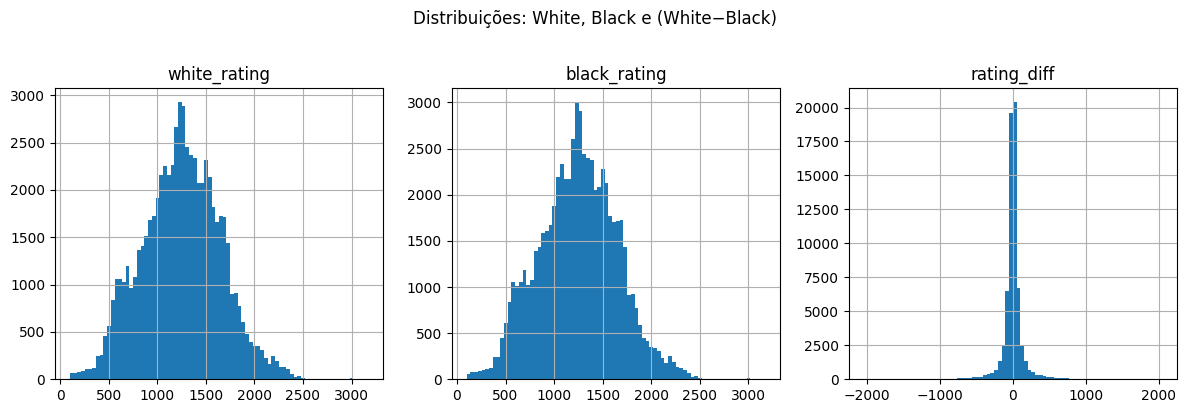



Proporção de resultados por faixa de rating_diff (% por linha)



white_result,50move,abandoned,agreed,checkmated,insufficient,kingofthehill,repetition,resigned,stalemate,threecheck,timeout,timevsinsufficient,win
diff_bin,,,,,,,,,,,,,
≤ -200,0.0,3.3,0.8,22.9,0.4,1.5,0.4,24.2,0.4,2.2,30.1,0.4,13.5
-200 a -50,0.0,4.0,0.5,20.0,0.4,0.1,0.8,27.2,0.5,0.3,24.8,0.5,20.9
-50 a +50,0.0,1.9,0.4,12.4,0.6,0.0,1.3,17.2,0.8,0.0,14.2,0.9,50.3
+50 a +200,0.0,1.0,0.5,4.8,0.4,0.0,0.9,6.0,0.6,0.1,7.2,0.4,78.0
≥ +200,0.0,0.5,1.0,3.5,0.3,0.1,0.4,4.0,0.4,0.2,4.6,0.5,84.5


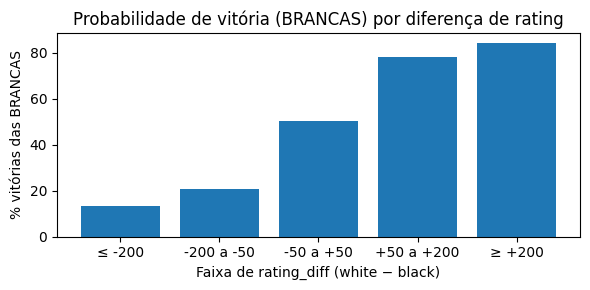

In [3]:
print("\nDistribuição de white_result & black_result\n")

white = dataset['white_result']
black = dataset['black_result']
resumo = (
    pd.concat([
        white.value_counts().rename('white_total'),
        (white.value_counts(normalize=True)*100).round(1).rename('white_%'),
        black.value_counts().rename('black_total'),
        (black.value_counts(normalize=True)*100).round(1).rename('black_%')
    ], axis=1)
    .reindex(fill_value=0)
)

# linha de total
resumo.loc['Total'] = [
    resumo['white_total'].sum(),
    resumo['white_%'].sum(),
    resumo['black_total'].sum(),
    resumo['black_%'].sum()
]
display(resumo)


# ====== time_class (com ordem) ======
tc_order = pd.Categorical(
    dataset['time_class'],
    categories=['bullet','blitz','rapid','daily'],
    ordered=True
)

tc_counts = (
    pd.Series(tc_order)
        .value_counts(sort=False)
        .rename('n')
        .to_frame()
        .assign(pct=lambda d: (d['n']/d['n'].sum()*100).round(1))
)

print("\n\nTime class — contagem e %\n")
display(tc_counts)



# ====== rules ======
rules_counts = (
    dataset['rules'].value_counts()
        .rename('n')
        .to_frame()
        .assign(pct=lambda d: (d['n']/d['n'].sum()*100).round(1))
)

print("\n\nRules — contagem e %\n")
display(rules_counts)



# ====== rating_diff e bins ======
bins   = [-np.inf, -200, -50, 50, 200, np.inf]
labels = ['≤ -200', '-200 a -50', '-50 a +50', '+50 a +200', '≥ +200']

rating_diff_dataset = (
    dataset
        .assign(rating_diff=lambda d: d['white_rating'] - d['black_rating'],
                diff_bin=lambda d: pd.cut(d['rating_diff'], bins=bins, labels=labels))
        .dropna(subset=['diff_bin','white_result'])
)

print("\n\nHistograma de ratings e rating_diff\n")
_ = ( # inicializar a variável evita que o array de valores seja printado
    rating_diff_dataset[['white_rating','black_rating','rating_diff']]
        .hist(bins=80, figsize=(12,4), layout=(1,3), sharey=False)
)

plt.suptitle('Distribuições: White, Black e (White−Black)', y=1.02)
plt.tight_layout()
plt.show()


# proporção do resultado por faixa de rating_diff (cada linha soma 100%)
tbl_diff = (
    rating_diff_dataset
        .groupby(['diff_bin','white_result'], observed=True)
        .size()
        .rename('n')
        .reset_index()
)

pct_diff = (
    tbl_diff
        .pivot(index='diff_bin', columns='white_result', values='n')
        .fillna(0)
)

pct_diff = (pct_diff.div(pct_diff.sum(axis=1), axis=0)*100).round(1)

print("\n\nProporção de resultados por faixa de rating_diff (% por linha)\n")
display(pct_diff)

# gráfico: % de vitória das BRANCAS por faixa
if 'win' in pct_diff.columns:
    fig, ax = plt.subplots(figsize=(6,3))
    ax.bar(pct_diff.index.astype(str), pct_diff['win'])
    ax.set_ylabel('% vitórias das BRANCAS')
    ax.set_xlabel('Faixa de rating_diff (white − black)')
    ax.set_title('Probabilidade de vitória (BRANCAS) por diferença de rating')
    plt.tight_layout()
    plt.show()

#### **Conslusão EDA**

**Balanceamento do alvo**

- white_result: vitórias das `BRANCAS` (\~50%), `PRETAS` (\~47%) e empates (\~3%), com variações por time_class.

- Em bullet/blitz o empate é raro; em rapid/daily aumenta.

&nbsp;

**Perfis de rating**

- white_rating e black_rating têm distribuições semelhantes (pico \~1200).

- rating_diff é centrado em 0, com caudas irrisórias, ou seja, a plataforma pareia jogadores com nível próximo.

&nbsp;

**Relação rating_diff -> resultado**

- O percentual de vitória das `BRANCAS` cresce com rating_diff:  
    - ≤-200 &rarr; baixa  
    - -50 a +50 &rarr; \~50%  
    - ≥+200 &rarr; \~80-85%.

Confirma que rating_diff será feature essencial.

&nbsp;

**Regras/variantes**

- Predomínio de rules == 'chess' (>98%); variantes são residuais.

## **4. Definição do target, variáveis e divisão dos dados**

### **4.1 Target**

- **Alvo binário**: `white_outcome` = 1 se win, 0 se not_win (draw ou lose).

- **Motivação**: draw é raro (~3%) e operacionalmente próximo de lose para o objetivo previsto.

&nbsp;

### **4.2 Features (pré-jogo)**

- Numéricas: rating_diff (white_rating - black_rating), rated (0/1).

- Categóricas: time_class &#8594; one-hot: tc_bullet, tc_blitz, tc_rapid, tc_daily.

- Eliminar colunas não utilizadas

&nbsp;

### **4.3 Transformações e prevenção de vazamento**

- Manter apenas partidas de xadrez clássico: rules == 'chess' (variantes são residuais >98% na EDA).

- One-hot em time_class (via pd.get_dummies).

- Sem padronização obrigatória (modelos de árvore/Naive Bayes não precisam); quando necessário (LR/KNN/SVM), usar Pipeline para ajustar apenas nos dados de treino e aplicar em validação/teste.

- Nenhuma informação de pós-jogo é utilizada.

&nbsp;

### **4.4 Divisão dos dados**

- Holdout 70/30, estratificado pelo alvo (win/not_win) para preservar proporções.

- Treino (70%) é usado para:
    - Cross-validation estratificada (k=10) para seleção do modelo (critério: menor LogLoss).
    - Ajuste de limiar τ (threshold) em um split interno do treino (20% do 70%), maximizando F1.

- Teste (30%) é apenas para avaliação final.

&nbsp;

### **4.5 Métricas e baselines**

- Métricas:
    - F1 (classe positiva = win) para decisão.
    - LogLoss e Brier para a qualidade/calibração das probabilidades.

- Baselines (calculados após o holdout, usando só o treino como referência):
    - Majoritária (classe constante).
    - Elo-only (probabilidade de win via fórmula logística em rating_diff).

## **5. Tratamento de dados e Pipeline de pré-processamento**

### **5.1 Filtragem, seleção de colunas e criação de features/target**

In [4]:
# filtrar somente xadrez clássico (decisão da EDA)
df = dataset.loc[dataset["rules"] == "chess"].copy()

# manter apenas colunas úteis
df = df[[
    "white_rating",
    "black_rating",
    "white_result",
    "time_class",
    "rated",
]]

# normalizar white_result -> white_outcome {win, not_win}
win_labels  = {"win"}
draw_labels = {"agreed","repetition","stalemate","50move","insufficient","timevsinsufficient"}
lose_labels = {"resigned","timeout","abandoned","checkmated"}

def white_result_to_outcome(x):
    if x in win_labels:  return "win"
    if x in draw_labels: return "not_win"
    if x in lose_labels: return "not_win"
    return None  # segurança. Não deve aparecer para nenhum valor.

df["white_outcome"] = df["white_result"].map(white_result_to_outcome)

# novas features
df["rated"] = df["rated"].astype(int)
df["rating_diff"] = df["white_rating"] - df["black_rating"]

# criar alvo binário (1=win, 0=not_win)
df["target_bin"] = (df["white_outcome"] == "win").astype(int)

# checagens rápidas & impactos da limpeza
n_before = len(dataset)
n_after  = len(df)
print(f"Registros: antes={n_before} | depois={n_after} (−{(1 - n_after/n_before)*100:.1f}%)")

# NADA pode ficar sem mapeamento
n_null = df["white_outcome"].isna().sum()
print("white_outcome nulos:", n_null)
if n_null > 0:
    display(df.loc[df["white_outcome"].isna(), "white_result"].value_counts())

print("\nDistribuição do alvo (target_bin):")
print(df["target_bin"].value_counts(normalize=True).mul(100).round(1))

display(df.head())

Registros: antes=66879 | depois=65778 (−1.6%)
white_outcome nulos: 0

Distribuição do alvo (target_bin):
target_bin
0    50.2
1    49.8
Name: proportion, dtype: float64


,white_rating,black_rating,white_result,time_class,rated,white_outcome,rating_diff,target_bin
0,1708,1608,win,daily,1,win,100,1
1,1726,1577,win,daily,1,win,149,1
2,1727,842,win,daily,1,win,885,1
3,819,1727,checkmated,daily,1,not_win,-908,0
4,1729,1116,win,daily,1,win,613,1


### **5.2 One-hot + alvo binário + Holdout**

Temos alguma opções para tratarmos as STRINGS da coluna `[time_class]`
Como sao 4 classes

1. `from sklearn.preprocessing import OrdinalEncoder`: serializa as classificações de tempo com um número distinto para cada. É o método mais simples, porém esta técnica poderia confundir o modelo, uma vez que estes números não possuem relevância hierarquica.

2. `from sklearn.preprocessing import OneHotEncoder`: pivota as classificações de tempo, criando novos atributos (colunas) para cada um dos valores existentes na tabela, atribuindo valores de 0 (false) ou 1 (true) para cada. Este método otimiza o uso de memória ram ao fazer o "Compressed Sparse Row", "guardando" apenas as informações "true" para cada coluna e ignorando as demais.

3. `pd.get_dummies`: função nativa da biblioteca pandas, mais simples de utilizar e com output similar ao OneHotEncoder, porém exibe os valores "false" e não possui compressão. Visto que são apenas cerca de 60 mil linhas, a economia de memória ram é irrisória.


Seguirei com a solução nativa da biblioteca pandas por questões de simplicidade, familiaridade e consistência de bibliotecas utilizadas para Cleaning e Preprocessing.

In [5]:
# partir do df limpo feitona etapa anterior
df_model = df[["white_rating","black_rating","rated","time_class",
               "rating_diff","white_outcome","target_bin"]].copy()

# one-hot de time_class
tc_categories = ["bullet","blitz","rapid","daily"]
df_model["time_class"] = pd.Categorical(
    df_model["time_class"],
    categories=tc_categories,
    ordered=True
)

dummies_tc = pd.get_dummies(df_model["time_class"], prefix="tc", dtype=int)

# mantem a ordem das colunas
dummies_tc = dummies_tc.reindex(columns=[f"tc_{c}" for c in tc_categories], fill_value=0)

# montar dataset final para modelagem
df_model = (
    df_model
        .drop(columns=["time_class"]) # remove original
        .join(dummies_tc)             # adiciona dummies
)

# X, y e holdout 70/30 estratificado
feature_cols = ["rating_diff","rated","tc_bullet","tc_blitz","tc_rapid","tc_daily"]
X = df_model[feature_cols].copy()
y = df_model["target_bin"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED
)

print("Shapes  ->  X_train:", X_train.shape, "| X_test:", X_test.shape)
print("\n\nDistribuição do y (train):")
print(y_train.value_counts(normalize=True).mul(100).round(1))
print("\n\nDistribuição do y (test):")
print(y_test.value_counts(normalize=True).mul(100).round(1))

Shapes  ->  X_train: (46044, 6) | X_test: (19734, 6)


Distribuição do y (train):
target_bin
0    50.2
1    49.8
Name: proportion, dtype: float64


Distribuição do y (test):
target_bin
0    50.2
1    49.8
Name: proportion, dtype: float64


## **6. Baseline e modelos candidatos**

#### **Baseline 1 — Classe Majoritária (DummyClassifier)**

**Objetivo**

Estabelecer uma referência mínima de desempenho usando o DummyClassifier:

- `strategy="most_frequent"` para predição hard (sempre a classe mais frequente do treino) — comparável via F1.

- `strategy="prior"` para predição soft (probabilidades iguais à prevalência do treino) — comparável via LogLoss.

**O que esperar das métricas**

 - **F1**: tipicamente baixo, pois o modelo acerta apenas a classe majoritária e zera o recall da minoritária.

- **Log Loss**: com prior, tende a ser melhor do que uma predição 0/1 “super confiante”, mas ainda serve apenas como piso a ser superado.

**Critério de sucesso para os modelos**

- F1 maior que o do DummyClassifier (most_frequent).

- LogLoss menor que o do DummyClassifier (prior).

&nbsp;

---

&nbsp;  

#### **Baseline 2 — Elo-only (por que e como)**

**Objetivo**

Usar apenas a diferença de rating (rating_diff = white_rating - black_rating) para estimar as probabilidades de win/draw/lose antes do jogo. Este é um baseline forte porque o Elo já carrega muito sinal preditivo. Mais infdormações em [Elo_rating_system](https://en.wikipedia.org/wiki/Elo_rating_system).


Isto é, pelo Elo, considerando que $ {Δ = rating_diff} $, o score esperado das brancas é:

$$ Ewhite = {1 \over 1 + 10^{−Δ/400}} $$

Esse score equivale a $ P(win) + 0.5 ⋅ P(draw) $

**O que esperar das métricas**

- Em geral, este baseline supera a classe majoritária em F1 e Log Loss.
- Se o seu modelo não superar o Elo-only, é sinal de que precisa rever features/splits.

**Critério de sucesso para os modelos.**

 - F1 maior que o Elo-only no teste.
 - Log Loss menor que o Elo-only no teste.

In [6]:
# Baseline — DummyClassifier (oficial)
dummy_hard  = DummyClassifier(strategy="most_frequent", random_state=SEED).fit(X_train, y_train)
y_dummy     = dummy_hard.predict(X_test)

dummy_prior = DummyClassifier(strategy="prior", random_state=SEED).fit(X_train, y_train)
proba_dummy = dummy_prior.predict_proba(X_test)[:, 1]  # P(win)

base_dummy_f1  = f1_score(y_test, y_dummy)
base_dummy_log = log_loss(y_test, proba_dummy)

# Baseline — Elo-only (binário)
proba_elo = 1.0 / (1.0 + 10.0 ** (-(X_test['rating_diff'] / 400.0)))  # P(win)
y_pred_elo = (proba_elo >= 0.5).astype(int)

base_elo_f1  = f1_score(y_test, y_pred_elo)
base_elo_log = log_loss(y_test, proba_elo)

# Resumo
res_base = pd.DataFrame({
    'Modelo'  : ['Dummy (most_frequent/prior)', 'Elo-only'],
    'F1'      : [base_dummy_f1,                  base_elo_f1],
    'LogLoss' : [base_dummy_log,                 base_elo_log],
})
display(res_base.round(4))

,Modelo,F1,LogLoss
0,Dummy (most_frequent/prior),0.0000,0.6931
1,Elo-only,0.6969,0.6240


## **7. Validação e Otimização de Hiperparâmetros**

### **7.1 Seleção de modelos com Cross Validation (CV)**

Tabela com as estatisticas de Log Loss e F1]


,model,cv_logloss_mean,cv_logloss_std,cv_f1_mean,cv_f1_std
0,LR,0.616,0.007,0.694,0.007
4,NB,0.631,0.004,0.710,0.007
1,RF,0.853,0.046,0.692,0.009
3,CART,1.482,0.059,0.687,0.010
2,KNN,2.196,0.124,0.661,0.004


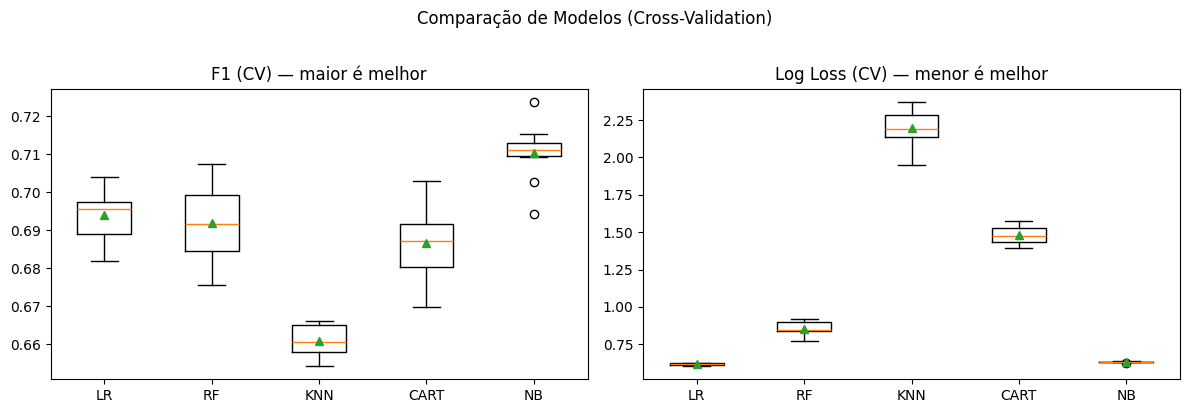

In [7]:
cv = StratifiedKFold(n_splits=kfold_partitions, shuffle=True, random_state=SEED)
scoring = {'logloss': 'neg_log_loss', 'f1': 'f1'}  # F1 do positivo (classe 1)

models = [
    ('LR',   Pipeline([('scaler', StandardScaler()),  ('clf', LogisticRegression(max_iter=100, random_state=SEED))])),
    ('RF',   Pipeline([('scaler', 'passthrough'),     ('clf', RandomForestClassifier(n_estimators=200, random_state=SEED))])),
    ('KNN',  Pipeline([('scaler', StandardScaler()),  ('clf', KNeighborsClassifier())])),
    ('CART', Pipeline([('scaler', 'passthrough'),     ('clf', DecisionTreeClassifier(random_state=SEED))])),
    ('NB',   Pipeline([('scaler', 'passthrough'),     ('clf', GaussianNB())])),
    ('SVM',  Pipeline([('scaler', StandardScaler()),  ('clf', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=SEED))]))
]

rows, names, res_f1, res_ll = [], [], [], []
for name, est in models:
    if name == 'SVM' and not run_svm:
        continue
    scores = cross_validate(est, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    rows.append({
        'model'        : name,
        'cv_logloss_mean': -scores['test_logloss'].mean(),
        'cv_logloss_std' :  scores['test_logloss'].std(),
        'cv_f1_mean'     :  scores['test_f1'].mean(),
        'cv_f1_std'      :  scores['test_f1'].std(),
    })
    names.append(name)
    res_f1.append(scores['test_f1'])          # vetor k-fold
    res_ll.append(-scores['test_logloss'])    # positivo

cv_table = pd.DataFrame(rows).sort_values('cv_logloss_mean')

print('Tabela com as estatisticas de Log Loss e F1]')
display(cv_table.round(3))
print('\n\n')


# ==== Box Plot F1 e Log-Loss ====
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Boxplot 1 — F1
axes[0].boxplot(res_f1, showmeans=True)
axes[0].set_title('F1 (CV) — maior é melhor')
axes[0].set_xticklabels(names, rotation=0)

# Boxplot 2 — Log Loss
axes[1].boxplot(res_ll, showmeans=True)
axes[1].set_title('Log Loss (CV) — menor é melhor')
axes[1].set_xticklabels(names, rotation=0)

fig.suptitle('Comparação de Modelos (Cross-Validation)', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

### **7.2 Escolha do melhor modelo**

Selecionei o modelo pelo menor LogLoss em CV. Para a decisão binária, mantive o limiar fixo τ = 0.50 (padrão argmax), por simplicidade e neutralidade na comparação entre modelos.

No conjunto de teste (30%), estipulo F1@τ=0.50 (desempenho operacional) e a qualidade das probabilidades via LogLoss e Brier score — seguindo o mesmo protocolo de treino/validação e evitando data leakage.

In [8]:
# === Seleciona o melhor modelo do CV e treina nos 70% ===
best_name = cv_table.iloc[0]['model']
best_est  = dict(models)[best_name]
best_est.fit(X_train, y_train)

# Probabilidade de "win" (classe 1) no TESTE
proba_test = best_est.predict_proba(X_test)[:, 1]

# Predição binária com o τ escolhido
y_pred_tau = (proba_test >= TAU).astype(int)

print("========== Report de Classificação ==========\n")
print(classification_report(y_test, y_pred_tau, digits=3))

# Resumo compacto em DataFrame
print("\n\n========== Overall do modelo ==========\n")
res_model = pd.DataFrame([{
    'Modelo'      : best_name,
    'Precision'   : precision_score(y_test, y_pred_tau),
    'Recall'      : recall_score(y_test, y_pred_tau),
    'Threshold τ' : round(TAU, 2),
    'F1'          : f1_score(y_test, y_pred_tau),
    'LogLoss'     : log_loss(y_test, proba_test),
    'Brier'       : brier_score_loss(y_test, proba_test),
}])
display(res_model.round(4))

========== Report de Classificação ==========

              precision    recall  f1-score   support

           0      0.697     0.696     0.696      9899
           1      0.694     0.696     0.695      9835

    accuracy                          0.696     19734
   macro avg      0.696     0.696     0.696     19734
weighted avg      0.696     0.696     0.696     19734



========== Overall do modelo ==========



,Modelo,Precision,Recall,Threshold τ,F1,LogLoss,Brier
0,LR,0.6943,0.6961,0.5,0.6952,0.6171,0.2087


### **7.3 Matriz de confusão**

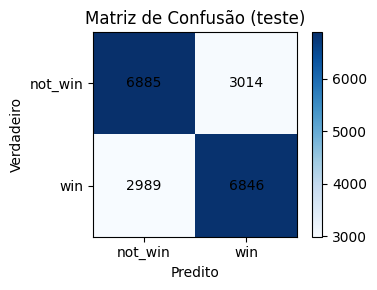

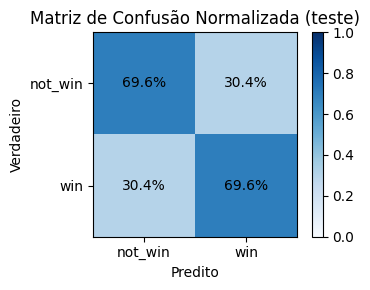

In [9]:
# === Relatório e Matriz de confusão (com τ) ===
cm = confusion_matrix(y_test, y_pred_tau)
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
im = ax.imshow(cm, cmap='Blues')
for (i,j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['not_win','win']); ax.set_yticklabels(['not_win','win'])
ax.set_xlabel('Predito')
ax.set_ylabel('Verdadeiro')
ax.set_title('Matriz de Confusão (teste)')
plt.colorbar(im)
plt.tight_layout()
plt.show()

print("\n\n")


# Matriz normalizada por classe verdadeira (percentual)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
im = ax.imshow(cm_norm, cmap='Blues', vmin=0, vmax=1)
for (i,j), v in np.ndenumerate(cm_norm):
    ax.text(j, i, f"{v*100:.1f}%", ha='center', va='center')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['not_win','win'])
ax.set_yticklabels(['not_win','win'])
ax.set_xlabel('Predito')
ax.set_ylabel('Verdadeiro')
ax.set_title('Matriz de Confusão Normalizada (teste)')
plt.colorbar(im)
plt.tight_layout()
plt.show()

## **8. Avaliação final, análise de erros e limitações**

### **8.1 Comparação no conjunto de teste (30%)**

In [10]:
# ===== Recalcular baselines no TESTE =====
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    f1_score, precision_score, recall_score, log_loss,
    roc_auc_score, average_precision_score, confusion_matrix
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Baseline 1 — Majoritária (estimada no TREINO)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
proba_dummy = dummy.predict_proba(X_test)[:, 1]
y_pred_dummy = dummy.predict(X_test)

# Baseline 2 — Elo-only (P(win) pela logística do Elo usando rating_diff)
proba_elo = 1.0 / (1.0 + 10.0 ** (-(X_test["rating_diff"] / 400.0)))
y_pred_elo = (proba_elo >= 0.50).astype(int)  # threshold padrão

# ===== Modelo escolhido (já treinado em 70%) =====
# Usa as variáveis já existentes: best_est, proba_test, y_pred_tau, TAU

# ===== Tabela comparativa =====
def _row(nome, y_true, y_pred, proba):
    return {
        "Modelo": nome,
        "Precision": precision_score(y_true, y_pred),
        "Recall":    recall_score(y_true, y_pred),
        "F1":        f1_score(y_true, y_pred),
        "ROC-AUC":   roc_auc_score(y_true, proba),
        "PR-AUC":    average_precision_score(y_true, proba),
        "LogLoss":   log_loss(y_true, proba),
    }

comp = pd.DataFrame([
    _row("Majoritária", y_test, y_pred_dummy, proba_dummy),
    _row("Elo-only",    y_test, y_pred_elo,   proba_elo),
    _row(f"{best_name} (τ={TAU:.2f})", y_test, y_pred_tau, proba_test),
])

display(comp.round(4).sort_values("LogLoss"))


,Modelo,Precision,Recall,F1,ROC-AUC,PR-AUC,LogLoss
2,LR (τ=0.50),0.6943,0.6961,0.6952,0.7632,0.7385,0.6171
1,Elo-only,0.6907,0.7032,0.6969,0.7634,0.7377,0.6240
0,Majoritária,0.0000,0.0000,0.0000,0.5000,0.4984,17.9634


### **8.2 Curvas - ROC e Precision-Recall**

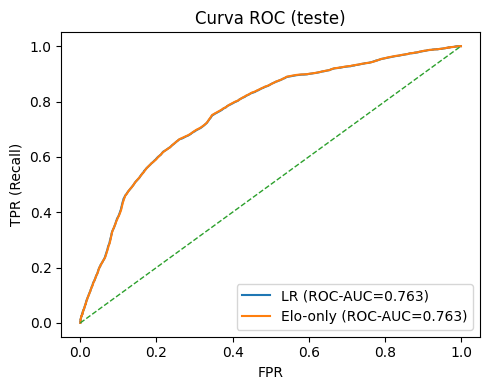

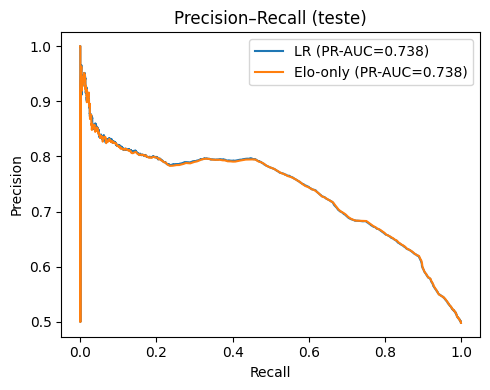

In [ ]:
# ROC
fpr_m, tpr_m, _ = roc_curve(y_test, proba_test)
fpr_e, tpr_e, _ = roc_curve(y_test, proba_elo)

plt.figure(figsize=(5,4))
plt.plot(fpr_m, tpr_m, label=f"{best_name} (ROC-AUC={roc_auc_score(y_test, proba_test):.3f})")
plt.plot(fpr_e, tpr_e, label=f"Elo-only (ROC-AUC={roc_auc_score(y_test, proba_elo):.3f})")
plt.plot([0,1],[0,1],"--", lw=1)
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("Curva ROC (teste)")
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall
prec_m, rec_m, _ = precision_recall_curve(y_test, proba_test)
prec_e, rec_e, _ = precision_recall_curve(y_test, proba_elo)

plt.figure(figsize=(5,4))
plt.plot(rec_m, prec_m, label=f"{best_name} (PR-AUC={average_precision_score(y_test, proba_test):.3f})")
plt.plot(rec_e, prec_e, label=f"Elo-only (PR-AUC={average_precision_score(y_test, proba_elo):.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (teste)")
plt.legend()
plt.tight_layout()
plt.show()


### **8.3 Limitações e próximos passos (texto curto)**

#### **8.3.1 Comparação: meu melhor modelo vs. baselines**

- **Melhor modelo**: Logistic Regression (LR), escolhido pelo menor LogLoss em CV.

- **Teste**: com τ = 0.50

- **LR (τ = 0.50)**: precisão, recall e F1 ficam bem equilibrados, com LogLoss ligeiramente menor do que o baseline Elo-only (melhor calibração).

- **Elo**: empata com a LR em discriminação (ROC/PR) e fica muito próximo em F1, mas perde um pouco em LogLoss.

- **Majoritária**: desempenho muito inferior (F1 quase igual a 0; LogLoss alto).

- **Minha leitura**: LR e Elo-only empatam em discriminação (ROC/PR) e em F1; o LR me dá um pequeno ganho em LogLoss (probabilidades mais bem calibradas). Na prática, o Elo já é muito forte; uso LR quando preciso de probabilidades melhores.

&nbsp;

#### **8.2 Análise de erros (τ ajustado)**

- Com τ = 0.50, os erros ficam relativamente simétricos entre win e not_win na matriz de confusão, o que demonstra um bom equilíbrio precisão/recall

- Assim, existe um trade-off em função do valor escolhido para τ:
    - Se abaixar τ (ex.: 0.40), o recall de win aumenta, ou seja, pego mais vitórias, entretanto também aumenta os False-Positives.

    - Se aumentar τ (ex.: 0.60), os False-Positives reduzem, deixando o modelo mais conservador para declarar “win”, entretanto recall diminui, isto é, os False-Negatives aumentam

&nbsp;

#### **8.3 Limitações**

- **Dados & escopo**: trabalhei com uma amostra do Chess.com; é possível que tenha ocorrido viéses de nível, ritmo e até mesmo época. Além disso, utilizei apenas variávels pré-jogo, sem levar em consideração lances do desenrolar das partidas.

- **Calibração**: não calibrei probabilidades (Platt/Isotônica). É possível que este modelo necessite de algumas probabilidades mais bem calibradas.

- **Limiar (τ)**: outra possibilidade seria fixar τ por critério de negócio (ex.: recall mínimo), o que poderia alterar dramaticamente estes resultados.

- **Features**: a base é enxuta. Para otimizar este modelo, seria necessário enriquece-lo com histórico recente, mais dados e outras features como volatilidade do rating, probabilidade de ECO, frequência de jogo etc.

- **Validação**: usei holdout 70/30 + CV simples; uma outra melhoria seria testar estratificação por time_class e validação temporal, se o modelo fosse enriquecido com a data/hora.

## **9. Conclusões e próximos passos**

### **9.1 Conclusão das Análsies**

- Por si só, Elo já explica quase tudo que precisaríamos para prever win das `BRANCAS` no pré-jogo.

- A Logistic Regression fica empatada com o Elo em F1/ROC/PR e ainda melhora um pouco a qualidade das probabilidades (LogLoss).

- Se optarmos por simplicidade, o Elo já é uma referência excelente. Entretanto, se o foco for obter probabilidades úteis para ranking/risco/τ, a LR seria mais indicada, coma possibilidade de calibração.

&nbsp;

### **9.2 Recomendação**

- Recomendação imediata: manter o Elo Rating como baseline e usar LR apenas quando precisar de probabilidades mais bem comportadas, como para apostas.

- Política de τ (decisão):

    - Para capturar mais vitórias, usar τ = 0.40 - aceitando mais falsos “win”.

    - Para reduzire falsos “win”, usar `0.50 <= τ <=  0.60` - mais conservadora, porém menor recall

&nbsp;

### **9.3 Meus próximos passos**

- Calibrar as probabilidades (Platt ou Isotônica) e reavaliar LogLoss/Brier.

- Testar modelos por ritmo (time_class) e/ou stacking Elo + LR.

- Criar novas features (histórico recente, volatilidade, prob. de ECO, intensidade de jogo).

- Fazer tuning e explorar validação temporal.


## **10. Salvando artefatos (modelos e pipeline)**

Não consegui rodar o modelo com o SVM. Demora horas e não finaliza.

O meu treinamento completo (sem SVM) leva em média 85 segundos (1:25 min num sample de 1o tentativas que realizei) no Colab. Por isso, não preciso carregar o modelo a partir de artefato neste notebook. Ainda assim, para reprodutibilidade, salvei o .joblib em repositório remoto no GitHub. Se, no futuro, o tempo de treino aumentar ou eu precisar apenas inferir, basta carregar o arquivo salvo em vez de treinar novamente.

In [12]:
# ====== Finalizar Temporizador ======
elapsed = time.perf_counter() - t0
h, rem = divmod(elapsed, 3600)
m, s = divmod(rem, 60)
print(f"Tempo total: {int(h):02d}h {int(m):02d}m {s:05.2f}s")


# ====== Salvar o JOBLIB Arquivo em Downloads
# Descomenmte o Codigo abaixo caso queira salvar o .joblib  localmente

# import sklearn # para capturar a versão
# from google.colab import files

# artefato = {
#     "model_name": best_name,             # ex.: 'LR'
#     "pipeline":   best_est,              # Pipeline já treinado nos 70%
#     "threshold":  float(TAU),            # seu τ escolhido (ex.: 0.50)
#     "features":   feature_cols,          # ordem esperada das colunas
#     "positive_label": 1,                 # target_bin: 1 = win
#     "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
#     "versions": {
#         "sklearn": sklearn.__version__,
#         "numpy":   np.__version__,
#         "pandas":  pd.__version__
#     }
# }

# # salva localmente
# joblib.dump(artefato, "modelo_win_notwin.joblib")

# # baixar o arquivo
# files.download("/content/modelo_win_notwin.joblib")

Tempo total: 00h 01m 26.43s
